# DSMarket - Clustering

### 1. Instalacion de paquetes 

In [1]:
!pip install seaborn
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## 2. Importacion de librerias

In [2]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 3. Carga de datos

In [3]:
df = pd.read_parquet("df_sales_week.parquet", engine="pyarrow")
print(df.shape)
df.head(3)

(8354260, 12)


,id,item,category,department,store,store_code,region,yearweek,n_sales,revenue,avg_sell_price,event
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201104,0,0.0,12.7414,Without event
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201105,0,0.0,12.7414,Without event
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201106,0,0.0,12.7414,SuperBowl


## 4. Exploratory Data Analysis (EDA)

In [4]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos")

def unique_counts(df: pd.DataFrame) -> pd.DataFrame:
    """
    Retorna un DataFrame con la cantidad de valores únicos por columna.
    
    Parámetros:
        df (pd.DataFrame): DataFrame de entrada
    
    Retorna:
        pd.DataFrame: columnas y cantidad de valores únicos
    """
    result = pd.DataFrame({
        "columna": df.columns,
        "valores_unicos": [df[col].nunique(dropna=False) for col in df.columns]
    })
    return result

In [5]:
report_df(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              object 
 1   item            object 
 2   category        object 
 3   department      object 
 4   store           object 
 5   store_code      object 
 6   region          object 
 7   yearweek        object 
 8   n_sales         int64  
 9   revenue         float64
 10  avg_sell_price  float64
 11  event           object 
dtypes: float64(2), int64(1), object(9)
memory usage: 764.9+ MB
None

Tenemos un total de 0 nulos


In [6]:
unique_counts(df)

,columna,valores_unicos
0,id,30490
1,item,3049
2,category,3
3,department,7
4,store,10
5,store_code,10
6,region,3
7,yearweek,274
8,n_sales,1093
9,revenue,57240


In [7]:
# Asignar 'id' como índice
df = df.set_index("id", drop=True)

In [8]:
df.head(3)

,item,category,department,store,store_code,region,yearweek,n_sales,revenue,avg_sell_price,event
id,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201104,0,0.0,12.7414,Without event
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201105,0,0.0,12.7414,Without event
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201106,0,0.0,12.7414,SuperBowl


## 5. Clustering productos

### 5.1. Agrupar ventas por producto-semana

In [9]:
df_items = (
    df.groupby(["item", "category", "department", "yearweek", "event"], as_index=False)
    .agg(
        n_sales=("n_sales", "sum"),
        revenue=("revenue", "sum"),
        avg_sell_price=("avg_sell_price", "mean"),
    )
)

In [10]:
df_items

,item,category,department,yearweek,event,n_sales,revenue,avg_sell_price
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,201104,Without event,0,0.0,11.95936
1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,201105,Without event,0,0.0,11.95936
2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,201106,SuperBowl,0,0.0,11.95936
3,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,201107,Valentine's Day,0,0.0,11.95936
4,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,201108,Without event,0,0.0,11.95936
...,...,...,...,...,...,...,...,...
835421,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,201612,Without event,163,195.6,1.20000
835422,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,201613,Easter,183,219.6,1.20000
835423,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,201614,Without event,197,236.4,1.20000
835424,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,201615,Without event,169,202.8,1.20000


### 5.2. Agregar features

In [11]:
# Features básicos por item
features_item = (
    df_items.groupby("item")
    .agg(
        mean_sales=("n_sales", "mean"),
        std_sales=("n_sales", "std"),
        max_sales=("n_sales", "max"),
        min_sales=("n_sales", "min"),
        mean_revenue=("revenue", "mean"),
        std_revenue=("revenue", "std"),
        total_sales=("n_sales", "sum"),
        total_revenue=("revenue", "sum"),
        avg_price=("avg_sell_price", "mean"),
    )
    .reset_index()
)

# Coeficiente de variación
# features_item["cv_sales"] = features_item["std_sales"] / features_item["mean_sales"].replace(0, np.nan)
features_item["cv_revenue"] = features_item["std_revenue"] / features_item["mean_revenue"].replace(0, np.nan)

# % semanas con 0 ventas
pct_zero = (
    df_items.groupby("item")["n_sales"]
    .apply(lambda x: (x == 0).mean())
    .reset_index(name="pct_weeks_zero")
)

# % de ventas en semanas con evento
sales_event = (
    df_items.groupby(["item", "event"])["n_sales"].sum().reset_index()
)

sales_event_flag = (
    sales_event.groupby("item")
    .apply(lambda x: x.loc[x["event"] != "Without event", "n_sales"].sum() / x["n_sales"].sum())
    .reset_index(name="pct_sales_event")
)

# Unir todo
features_item = (
    features_item
    .merge(pct_zero, on="item", how="left")
    .merge(sales_event_flag, on="item", how="left")
    .fillna({"pct_sales_event": 0})
)


In [12]:
features_item.head(3)

,item,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,avg_price,cv_revenue,pct_weeks_zero,pct_sales_event
0,ACCESORIES_1_001,14.937956,15.358946,51,0,164.371399,168.868334,4093,45037.7634,11.469808,1.027358,0.470803,0.271195
1,ACCESORIES_1_002,18.463504,10.599975,102,0,97.474729,55.978003,5059,26708.0758,5.276746,0.574282,0.062044,0.289781
2,ACCESORIES_1_003,5.237226,7.703189,40,0,20.643590,30.411086,1435,5656.3437,3.947629,1.473149,0.598540,0.287805


### 5.3. Establecer numero de clusters

In [13]:
# Selección dinámica solo de variables numéricas
X = (
    features_item
    .select_dtypes(include=[np.number])   # solo numéricas
    .replace([np.inf, -np.inf], np.nan)   # manejar infinitos
    .fillna(0.0)                          # manejar nulos
)

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
sse = {}
for k in range(2, 15):   # probamos de 2 a 14 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    sse[k] = kmeans.inertia_


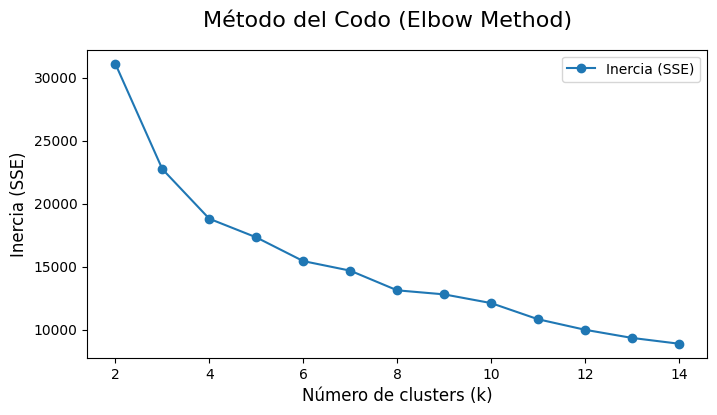

In [16]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, marker="o", label="Inercia (SSE)")
ax.set_xlabel("Número de clusters (k)", fontsize=12)
ax.set_ylabel("Inercia (SSE)", fontsize=12)
ax.legend()
fig.suptitle("Método del Codo (Elbow Method)", fontsize=16)
plt.show()

### 5.4. Creacion de pipeline

In [17]:
# Definir pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=4, random_state=175, n_init="auto"))
])

# Entrenar modelo
pipeline.fit(X)

# Obtener etiquetas de cluster
features_item["cluster"] = pipeline["kmeans"].labels_

In [18]:
# Distribución por cluster
print(features_item["cluster"].value_counts())

cluster
1    1853
0     956
2     229
3      11
Name: count, dtype: int64


In [19]:
features_item.head(3)

,item,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,avg_price,cv_revenue,pct_weeks_zero,pct_sales_event,cluster
0,ACCESORIES_1_001,14.937956,15.358946,51,0,164.371399,168.868334,4093,45037.7634,11.469808,1.027358,0.470803,0.271195,0
1,ACCESORIES_1_002,18.463504,10.599975,102,0,97.474729,55.978003,5059,26708.0758,5.276746,0.574282,0.062044,0.289781,1
2,ACCESORIES_1_003,5.237226,7.703189,40,0,20.643590,30.411086,1435,5656.3437,3.947629,1.473149,0.598540,0.287805,0


In [20]:
# Tomar las columnas categóricas únicas por item
df_cats = df_items[["item", "category", "department"]].drop_duplicates("item")

# Unirlas con tus features agregados
features_item = features_item.merge(df_cats, on="item", how="left")

In [21]:
df_items.shape

(835426, 8)

In [22]:
features_item.head(3)

,item,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,avg_price,cv_revenue,pct_weeks_zero,pct_sales_event,cluster,category,department
0,ACCESORIES_1_001,14.937956,15.358946,51,0,164.371399,168.868334,4093,45037.7634,11.469808,1.027358,0.470803,0.271195,0,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,18.463504,10.599975,102,0,97.474729,55.978003,5059,26708.0758,5.276746,0.574282,0.062044,0.289781,1,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,5.237226,7.703189,40,0,20.643590,30.411086,1435,5656.3437,3.947629,1.473149,0.598540,0.287805,0,ACCESORIES,ACCESORIES_1


In [23]:
features_item.to_csv("clustering_data.csv", index=False, encoding="utf-8")

In [24]:
pipeline["kmeans"].labels_.shape

(3049,)

In [25]:
pipeline[:2]

,steps,"[('scaler', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300


In [26]:
features_item["cluster"] = pipeline["kmeans"].labels_

In [27]:
features_item.head(3)

,item,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,avg_price,cv_revenue,pct_weeks_zero,pct_sales_event,cluster,category,department
0,ACCESORIES_1_001,14.937956,15.358946,51,0,164.371399,168.868334,4093,45037.7634,11.469808,1.027358,0.470803,0.271195,0,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,18.463504,10.599975,102,0,97.474729,55.978003,5059,26708.0758,5.276746,0.574282,0.062044,0.289781,1,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,5.237226,7.703189,40,0,20.643590,30.411086,1435,5656.3437,3.947629,1.473149,0.598540,0.287805,0,ACCESORIES,ACCESORIES_1


### 5.5. Verificacion de clusters por feature

In [28]:
(
    features_item
    .groupby(["cluster"])
    .describe()
    .T
    .style
    .format('{:.2f}')
    .background_gradient(cmap = 'Blues', axis = 1)
)

## 6. Ficha de productos

In [29]:
ficha_df = pd.DataFrame()

In [30]:
for i, col in enumerate(["pct_weeks_zero", "total_sales", "pct_sales_event", "avg_price"]):
    resumen_data = features_item[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = pd.concat([ficha_df, resumen_data])

In [31]:
ficha_df

cluster                          0             1              2             3
pct_weeks_zero  mean      0.517183      0.085572       0.115721  4.014599e-02
                std       0.134054      0.096264       0.141207  7.153657e-02
                min       0.160584      0.000000       0.000000  0.000000e+00
                25%       0.408759      0.000000       0.000000  0.000000e+00
                50%       0.503650      0.043796       0.054745  0.000000e+00
                75%       0.616788      0.153285       0.200730  5.656934e-02
                max       0.854015      0.383212       0.667883  1.970803e-01
total_sales     mean   7304.148536  16269.002698  101319.034934  4.876475e+05
                std    7829.210348  15033.476186   58070.389416  2.510614e+05
                min     568.000000    660.000000   16794.000000  2.605980e+05
                25%    2455.000000   5928.000000   58204.000000  3.293855e+05
                50%    4651.000000  11517.000000   86546.000000  3.961190e+05
                75%    9094.000000  21577.000000  129262.000000  5.282930e+05
                max   64073.000000  95171.000000  284333.000000  1.002529e+06
pct_sales_event mean      0.260658      0.270138       0.268294  2.721910e-01
                std       0.020125      0.013515       0.020320  7.074009e-03
                min       0.177835      0.226888       0.226375  2.585385e-01
                25%       0.250629      0.262562       0.259884  2.691666e-01
                50%       0.260710      0.269015       0.267736  2.756762e-01
                75%       0.271071      0.276114       0.274391  2.765543e-01
                max       0.375515      0.401437       0.472636  2.793146e-01
avg_price       mean      5.860251      5.580803       4.314357  2.602383e+00
                std       5.022422      4.212337       4.743964  1.512711e+00
                min       0.305900      0.305900       0.239566  1.577668e+00
                25%       2.793961      2.883230       1.221799  1.824300e+00
                50%       3.965358      4.539968       2.735505  1.911535e+00
                75%       7.322393      7.266964       4.852574  2.471643e+00
                max      37.596274     39.446470      30.680590  5.974191e+00

In [32]:
# generamos nuestro multiindex
out_index = [
    "Ventas",
    "Rotacion",
    "Estacionalidad",
    "Costo"
]

inner_index = [
    "pct_weeks_zero", "total_sales", "pct_sales_event", "avg_price"
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

In [33]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [34]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [35]:
tamaño_clusters = features_item.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [36]:
ficha_df = pd.concat([tamaño_clusters, ficha_df])

In [37]:
ficha_df

cluster                                                   0             1  \
Grupo Indicadores Indicador       Estadístico                               
General           Clúster         Tamaño         956.000000   1853.000000   
Ventas            pct_weeks_zero  Media            0.517183      0.085572   
                                  Desviación       0.134054      0.096264   
                                  Mínimo           0.160584      0.000000   
                                  Perc. 25         0.408759      0.000000   
                                  Perc. 50         0.503650      0.043796   
                                  Perc. 75         0.616788      0.153285   
                                  Máximo           0.854015      0.383212   
Rotacion          total_sales     Media         7304.148536  16269.002698   
                                  Desviación    7829.210348  15033.476186   
                                  Mínimo         568.000000    660.000000   
                                  Perc. 25      2455.000000   5928.000000   
                                  Perc. 50      4651.000000  11517.000000   
                                  Perc. 75      9094.000000  21577.000000   
                                  Máximo       64073.000000  95171.000000   
Estacionalidad    pct_sales_event Media            0.260658      0.270138   
                                  Desviación       0.020125      0.013515   
                                  Mínimo           0.177835      0.226888   
                                  Perc. 25         0.250629      0.262562   
                                  Perc. 50         0.260710      0.269015   
                                  Perc. 75         0.271071      0.276114   
                                  Máximo           0.375515      0.401437   
Costo             avg_price       Media            5.860251      5.580803   
                                  Desviación       5.022422      4.212337   
                                  Mínimo           0.305900      0.305900   
                                  Perc. 25         2.793961      2.883230   
                                  Perc. 50         3.965358      4.539968   
                                  Perc. 75         7.322393      7.266964   
                                  Máximo          37.596274     39.446470   

cluster                                                    2             3  
Grupo Indicadores Indicador       Estadístico                               
General           Clúster         Tamaño          229.000000  1.100000e+01  
Ventas            pct_weeks_zero  Media             0.115721  4.014599e-02  
                                  Desviación        0.141207  7.153657e-02  
                                  Mínimo            0.000000  0.000000e+00  
                                  Perc. 25          0.000000  0.000000e+00  
                                  Perc. 50          0.054745  0.000000e+00  
                                  Perc. 75          0.200730  5.656934e-02  
                                  Máximo            0.667883  1.970803e-01  
Rotacion          total_sales     Media        101319.034934  4.876475e+05  
                                  Desviación    58070.389416  2.510614e+05  
                                  Mínimo        16794.000000  2.605980e+05  
                                  Perc. 25      58204.000000  3.293855e+05  
                                  Perc. 50      86546.000000  3.961190e+05  
                                  Perc. 75     129262.000000  5.282930e+05  
                                  Máximo       284333.000000  1.002529e+06  
Estacionalidad    pct_sales_event Media             0.268294  2.721910e-01  
                                  Desviación        0.020320  7.074009e-03  
                                  Mínimo            0.226375  2.585385e-01  
                                  Perc. 25          0.259884  2.691666e-

In [38]:
float_format = '{:.2f}'

In [39]:
(
    ficha_df
    .rename(columns = {
        0 : "Menor Rotacion",
        1 : "Eventos",
        2 : "Top Ventas",
        3 : "Alto valor"
    })
    .style
    .format(float_format)
    .background_gradient(cmap = 'Blues', axis = 1)
)

## 7. Clustering tiendas

In [40]:
df.head(3)

,item,category,department,store,store_code,region,yearweek,n_sales,revenue,avg_sell_price,event
id,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201104,0,0.0,12.7414,Without event
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201105,0,0.0,12.7414,Without event
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201106,0,0.0,12.7414,SuperBowl


### 7.1. Agrupar ventas por tienda-semana

In [41]:
df_store = (
    df.groupby(["store_code", "store", "region", "event", "yearweek"], as_index=False)
    .agg(
        n_sales=("n_sales", "sum"),
        revenue=("revenue", "sum"),
    )
)

In [42]:
df_store

,store_code,store,region,event,yearweek,n_sales,revenue
0,BOS_1,South_End,Boston,Easter,201117,14178,46001.9457
1,BOS_1,South_End,Boston,Easter,201215,21574,71769.6207
2,BOS_1,South_End,Boston,Easter,201313,20627,69639.8697
3,BOS_1,South_End,Boston,Easter,201416,23694,80330.8765
4,BOS_1,South_End,Boston,Easter,201514,23625,91252.4845
...,...,...,...,...,...,...,...
2735,PHI_3,Queen_Village,Philadelphia,Without event,201610,28881,99141.1926
2736,PHI_3,Queen_Village,Philadelphia,Without event,201612,24897,84637.8643
2737,PHI_3,Queen_Village,Philadelphia,Without event,201614,29519,103434.2124
2738,PHI_3,Queen_Village,Philadelphia,Without event,201615,29007,99242.6841


### 7.2. Agregar features

In [43]:
# Features básicos por item
features_store = (
    df_store.groupby("store_code")
    .agg(
        mean_sales=("n_sales", "mean"),
        std_sales=("n_sales", "std"),
        max_sales=("n_sales", "max"),
        min_sales=("n_sales", "min"),
        mean_revenue=("revenue", "mean"),
        std_revenue=("revenue", "std"),
        total_sales=("n_sales", "sum"),
        total_revenue=("revenue", "sum"),
    )
    .reset_index()
)

# Coeficiente de variación
# features_item["cv_sales"] = features_item["std_sales"] / features_item["mean_sales"].replace(0, np.nan)
features_store["cv_revenue"] = features_store["std_revenue"] / features_store["mean_revenue"].replace(0, np.nan)

# % semanas con 0 ventas
pct_zero_store = (
    df_store.groupby("store_code")["n_sales"]
    .apply(lambda x: (x == 0).mean())
    .reset_index(name="pct_weeks_zero_store")
)

# % de ventas en semanas con evento
sales_event_store = (
    df_store.groupby(["store_code", "event"])["n_sales"].sum().reset_index()
)

sales_event_flag_store = (
    sales_event_store.groupby("store_code")
    .apply(lambda x: x.loc[x["event"] != "Without event", "n_sales"].sum() / x["n_sales"].sum())
    .reset_index(name="pct_sales_event_store")
)

# Unir todo
features_store = (
    features_store
    .merge(pct_zero_store, on="store_code", how="left")
    .merge(sales_event_flag_store, on="store_code", how="left")
    .fillna({"pct_sales_event_store": 0})
)


In [44]:
features_store.head(3)

,store_code,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,cv_revenue,pct_weeks_zero_store,pct_sales_event_store
0,BOS_1,20420.773723,2642.180722,25860,5243,70589.246838,12002.381750,5595292,1.934145e+07,0.170031,0.0,0.268776
1,BOS_2,26329.868613,3367.054601,34262,7789,92207.065652,12912.528175,7214384,2.526474e+07,0.140038,0.0,0.268629
2,BOS_3,22223.832117,3508.009935,29476,6036,80088.320897,18844.044880,6089330,2.194420e+07,0.235291,0.0,0.267757


### 7.3. Establecer numero de clusters para tiendas

In [45]:
# Selección dinámica solo de variables numéricas
X = (
    features_store
    .select_dtypes(include=[np.number])   # solo numéricas
    .replace([np.inf, -np.inf], np.nan)   # manejar infinitos
    .fillna(0.0)                          # manejar nulos
)

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
sse = {}
for k in range(2, 10):   # probamos de 2 a 14 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    sse[k] = kmeans.inertia_


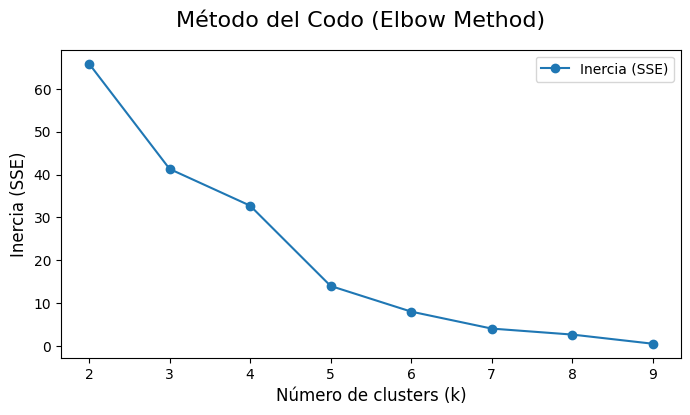

In [48]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, marker="o", label="Inercia (SSE)")
ax.set_xlabel("Número de clusters (k)", fontsize=12)
ax.set_ylabel("Inercia (SSE)", fontsize=12)
ax.legend()
fig.suptitle("Método del Codo (Elbow Method)", fontsize=16)
plt.show()

### 7.4. Creacion de pipeline

In [49]:
# Definir pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=4, random_state=175, n_init="auto"))
])

# Entrenar modelo
pipeline.fit(X)

# Obtener etiquetas de cluster
features_store["cluster"] = pipeline["kmeans"].labels_

In [50]:
# Distribución por cluster
print(features_store["cluster"].value_counts())

cluster
1    6
3    2
2    1
0    1
Name: count, dtype: int64


In [51]:
features_store.head(3)

,store_code,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,cv_revenue,pct_weeks_zero_store,pct_sales_event_store,cluster
0,BOS_1,20420.773723,2642.180722,25860,5243,70589.246838,12002.381750,5595292,1.934145e+07,0.170031,0.0,0.268776,3
1,BOS_2,26329.868613,3367.054601,34262,7789,92207.065652,12912.528175,7214384,2.526474e+07,0.140038,0.0,0.268629,1
2,BOS_3,22223.832117,3508.009935,29476,6036,80088.320897,18844.044880,6089330,2.194420e+07,0.235291,0.0,0.267757,1


In [52]:
df_store.head()

,store_code,store,region,event,yearweek,n_sales,revenue
0,BOS_1,South_End,Boston,Easter,201117,14178,46001.9457
1,BOS_1,South_End,Boston,Easter,201215,21574,71769.6207
2,BOS_1,South_End,Boston,Easter,201313,20627,69639.8697
3,BOS_1,South_End,Boston,Easter,201416,23694,80330.8765
4,BOS_1,South_End,Boston,Easter,201514,23625,91252.4845


In [53]:
# Tomar las columnas categóricas únicas por item
df_cats_store = df_store[["store_code", "store", "region"]].drop_duplicates("store_code")

# Unirlas con tus features agregados
features_store = features_store.merge(df_cats_store, on="store_code", how="left")

In [54]:
df_store.shape

(2740, 7)

In [55]:
features_store.head(3)

,store_code,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,cv_revenue,pct_weeks_zero_store,pct_sales_event_store,cluster,store,region
0,BOS_1,20420.773723,2642.180722,25860,5243,70589.246838,12002.381750,5595292,1.934145e+07,0.170031,0.0,0.268776,3,South_End,Boston
1,BOS_2,26329.868613,3367.054601,34262,7789,92207.065652,12912.528175,7214384,2.526474e+07,0.140038,0.0,0.268629,1,Roxbury,Boston
2,BOS_3,22223.832117,3508.009935,29476,6036,80088.320897,18844.044880,6089330,2.194420e+07,0.235291,0.0,0.267757,1,Back_Bay,Boston


In [56]:
features_store.to_csv("clustering_store_data.csv", index=False, encoding="utf-8")

In [57]:
pipeline["kmeans"].labels_.shape

(10,)

In [58]:
pipeline[:2]

,steps,"[('scaler', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300


In [59]:
features_store["cluster"] = pipeline["kmeans"].labels_

In [60]:
features_store.head(3)

,store_code,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,cv_revenue,pct_weeks_zero_store,pct_sales_event_store,cluster,store,region
0,BOS_1,20420.773723,2642.180722,25860,5243,70589.246838,12002.381750,5595292,1.934145e+07,0.170031,0.0,0.268776,3,South_End,Boston
1,BOS_2,26329.868613,3367.054601,34262,7789,92207.065652,12912.528175,7214384,2.526474e+07,0.140038,0.0,0.268629,1,Roxbury,Boston
2,BOS_3,22223.832117,3508.009935,29476,6036,80088.320897,18844.044880,6089330,2.194420e+07,0.235291,0.0,0.267757,1,Back_Bay,Boston


### 7.5. Verificacion de clusters por feature

In [61]:
(
    features_store
    .groupby(["cluster"])
    .describe()
    .T
    .style
    .format('{:.2f}')
    .background_gradient(cmap = 'Blues', axis = 1)
)

## 8. Ficha de tiendas

In [62]:
ficha_store = pd.DataFrame()

In [63]:
for i, col in enumerate(["mean_sales", "total_sales", "cv_revenue", "mean_revenue"]):
    resumen_data = features_store[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_store = pd.concat([ficha_store, resumen_data])

In [64]:
ficha_store

cluster                       0             1             2             3
mean_sales   mean  2.388326e+04  2.327509e+04  4.083277e+04  1.769885e+04
             std            NaN  3.469340e+03           NaN  3.849386e+03
             min   2.388326e+04  1.879220e+04  4.083277e+04  1.497692e+04
             25%   2.388326e+04  2.111839e+04  4.083277e+04  1.633788e+04
             50%   2.388326e+04  2.284145e+04  4.083277e+04  1.769885e+04
             75%   2.388326e+04  2.561217e+04  4.083277e+04  1.905981e+04
             max   2.388326e+04  2.809568e+04  4.083277e+04  2.042077e+04
total_sales  mean  6.544012e+06  6.377375e+06  1.118818e+07  4.849484e+06
             std            NaN  9.505992e+05           NaN  1.054732e+06
             min   6.544012e+06  5.149062e+06  1.118818e+07  4.103676e+06
             25%   6.544012e+06  5.786439e+06  1.118818e+07  4.476580e+06
             50%   6.544012e+06  6.258556e+06  1.118818e+07  4.849484e+06
             75%   6.544012e+06  7.017734e+06  1.118818e+07  5.222388e+06
             max   6.544012e+06  7.698216e+06  1.118818e+07  5.595292e+06
cv_revenue   mean  3.705530e-01  2.087077e-01  1.758320e-01  1.848913e-01
             std            NaN  6.472286e-02           NaN  2.101520e-02
             min   3.705530e-01  1.400384e-01  1.758320e-01  1.700313e-01
             25%   3.705530e-01  1.635377e-01  1.758320e-01  1.774613e-01
             50%   3.705530e-01  2.001989e-01  1.758320e-01  1.848913e-01
             75%   3.705530e-01  2.321905e-01  1.758320e-01  1.923213e-01
             max   3.705530e-01  3.176382e-01  1.758320e-01  1.997513e-01
mean_revenue mean  7.903830e+04  8.238140e+04  1.441488e+05  6.275125e+04
             std            NaN  1.238325e+04           NaN  1.108460e+04
             min   7.903830e+04  6.654501e+04  1.441488e+05  5.491325e+04
             25%   7.903830e+04  7.642509e+04  1.441488e+05  5.883225e+04
             50%   7.903830e+04  7.929093e+04  1.441488e+05  6.275125e+04
             75%   7.903830e+04  8.917738e+04  1.441488e+05  6.667025e+04
             max   7.903830e+04  1.012188e+05  1.441488e+05  7.058925e+04

In [65]:
# generamos nuestro multiindex
out_index_store = [
    "Rendimiento base",
    "Volumen total",
    "Estabilidad",
    "Rentabilidad"
]

inner_index_store = [
    "mean_sales", "total_sales", "cv_revenue", "mean_revenue"
]

estadisticos_store = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index_store = []

for oi, ii, in zip(out_index_store, inner_index_store):
    for es in estadisticos_store:
        new_multi_index_store.append((oi, ii, es))

In [66]:
# def generate_multiindex(list_of_tuples, names):
#     return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [67]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha_store = generate_multiindex(new_multi_index_store, names)
ficha_store.set_index(index_ficha_store, inplace = True)

In [68]:
tamaño_clusters_store = features_store.groupby("cluster").size().to_frame().T
tamaño_clusters_store.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [69]:
ficha_store = pd.concat([tamaño_clusters_store, ficha_store])

In [70]:
ficha_store

cluster                                                0             1  \
Grupo Indicadores Indicador    Estadístico                               
General           Clúster      Tamaño       1.000000e+00  6.000000e+00   
Rendimiento base  mean_sales   Media        2.388326e+04  2.327509e+04   
                               Desviación            NaN  3.469340e+03   
                               Mínimo       2.388326e+04  1.879220e+04   
                               Perc. 25     2.388326e+04  2.111839e+04   
                               Perc. 50     2.388326e+04  2.284145e+04   
                               Perc. 75     2.388326e+04  2.561217e+04   
                               Máximo       2.388326e+04  2.809568e+04   
Volumen total     total_sales  Media        6.544012e+06  6.377375e+06   
                               Desviación            NaN  9.505992e+05   
                               Mínimo       6.544012e+06  5.149062e+06   
                               Perc. 25     6.544012e+06  5.786439e+06   
                               Perc. 50     6.544012e+06  6.258556e+06   
                               Perc. 75     6.544012e+06  7.017734e+06   
                               Máximo       6.544012e+06  7.698216e+06   
Estabilidad       cv_revenue   Media        3.705530e-01  2.087077e-01   
                               Desviación            NaN  6.472286e-02   
                               Mínimo       3.705530e-01  1.400384e-01   
                               Perc. 25     3.705530e-01  1.635377e-01   
                               Perc. 50     3.705530e-01  2.001989e-01   
                               Perc. 75     3.705530e-01  2.321905e-01   
                               Máximo       3.705530e-01  3.176382e-01   
Rentabilidad      mean_revenue Media        7.903830e+04  8.238140e+04   
                               Desviación            NaN  1.238325e+04   
                               Mínimo       7.903830e+04  6.654501e+04   
                               Perc. 25     7.903830e+04  7.642509e+04   
                               Perc. 50     7.903830e+04  7.929093e+04   
                               Perc. 75     7.903830e+04  8.917738e+04   
                               Máximo       7.903830e+04  1.012188e+05   

cluster                                                2             3  
Grupo Indicadores Indicador    Estadístico                              
General           Clúster      Tamaño       1.000000e+00  2.000000e+00  
Rendimiento base  mean_sales   Media        4.083277e+04  1.769885e+04  
                               Desviación            NaN  3.849386e+03  
                               Mínimo       4.083277e+04  1.497692e+04  
                               Perc. 25     4.083277e+04  1.633788e+04  
                               Perc. 50     4.083277e+04  1.769885e+04  
                               Perc. 75     4.083277e+04  1.905981e+04  
                               Máximo       4.083277e+04  2.042077e+04  
Volumen total     total_sales  Media        1.118818e+07  4.849484e+06  
                               Desviación            NaN  1.054732e+06  
                               Mínimo       1.118818e+07  4.103676e+06  
                               Perc. 25     1.118818e+07  4.476580e+06  
                               Perc. 50     1.118818e+07  4.849484e+06  
                               Perc. 75     1.118818e+07  5.222388e+06  
                               Máximo       1.118818e+07  5.595292e+06  
Estabilidad       cv_revenue   Media        1.758320e-01  1.848913e-01  
                               Desviación            NaN  2.101520e-02  
                               Mínimo       1.758320e-01  1.700313e-01  
                               Perc. 25     1.758320e-01  1.774613e-01  
                               Perc. 50     1.758320e-01  1.848913e-01  
                               Perc. 75     1.758320e-01  1.923213e-01  
                          

In [71]:
float_format = '{:.2f}'

In [72]:
(
    ficha_store
    .rename(columns = {
        0 : "Tiendas irregulares",
        1 : "Tiendas estables",
        2 : "Tiendas premium",
        3 : "Tiendas bajo rendimiento"
    })
    .style
    .format(float_format)
    .background_gradient(cmap = 'Blues', axis = 1)
)

## 9. Creacion fichero para forecasting

In [73]:
df.head(3)

,item,category,department,store,store_code,region,yearweek,n_sales,revenue,avg_sell_price,event
id,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201104,0,0.0,12.7414,Without event
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201105,0,0.0,12.7414,Without event
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201106,0,0.0,12.7414,SuperBowl


In [74]:
df = df.reset_index()

In [75]:
features_store.head(3)

,store_code,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,cv_revenue,pct_weeks_zero_store,pct_sales_event_store,cluster,store,region
0,BOS_1,20420.773723,2642.180722,25860,5243,70589.246838,12002.381750,5595292,1.934145e+07,0.170031,0.0,0.268776,3,South_End,Boston
1,BOS_2,26329.868613,3367.054601,34262,7789,92207.065652,12912.528175,7214384,2.526474e+07,0.140038,0.0,0.268629,1,Roxbury,Boston
2,BOS_3,22223.832117,3508.009935,29476,6036,80088.320897,18844.044880,6089330,2.194420e+07,0.235291,0.0,0.267757,1,Back_Bay,Boston


In [76]:
features_item.head(3)

,item,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,avg_price,cv_revenue,pct_weeks_zero,pct_sales_event,cluster,category,department
0,ACCESORIES_1_001,14.937956,15.358946,51,0,164.371399,168.868334,4093,45037.7634,11.469808,1.027358,0.470803,0.271195,0,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,18.463504,10.599975,102,0,97.474729,55.978003,5059,26708.0758,5.276746,0.574282,0.062044,0.289781,1,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,5.237226,7.703189,40,0,20.643590,30.411086,1435,5656.3437,3.947629,1.473149,0.598540,0.287805,0,ACCESORIES,ACCESORIES_1


In [77]:
cluster_store = features_store[["store_code", "cluster"]].drop_duplicates()
cluster_item = features_item[["item", "cluster"]].drop_duplicates()

In [78]:
cluster_store

,store_code,cluster
0,BOS_1,3
1,BOS_2,1
2,BOS_3,1
3,NYC_1,1
4,NYC_2,1
5,NYC_3,2
6,NYC_4,3
7,PHI_1,1
8,PHI_2,0
9,PHI_3,1


In [79]:
cluster_item

,item,cluster
0,ACCESORIES_1_001,0
1,ACCESORIES_1_002,1
2,ACCESORIES_1_003,0
3,ACCESORIES_1_004,1
4,ACCESORIES_1_005,1
...,...,...
3044,SUPERMARKET_3_823,1
3045,SUPERMARKET_3_824,1
3046,SUPERMARKET_3_825,1
3047,SUPERMARKET_3_826,0


In [80]:
df.shape

(8354260, 12)

In [81]:
df = (
    df
    .merge(cluster_store, on="store_code", how="left")
    .rename(columns={'cluster': 'cluster_store'})
    .merge(cluster_item, on="item", how="left")
    .rename(columns={'cluster': 'cluster_item'})
)

In [82]:
df.shape

(8354260, 14)

In [83]:
df.head(3)

,id,item,category,department,store,store_code,region,yearweek,n_sales,revenue,avg_sell_price,event,cluster_store,cluster_item
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201104,0,0.0,12.7414,Without event,3,0
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201105,0,0.0,12.7414,Without event,3,0
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201106,0,0.0,12.7414,SuperBowl,3,0


In [84]:
df.to_parquet('df_forecasting.parquet', engine='pyarrow', index=False, compression='snappy')